In [7]:
import datetime
from dateutil.parser import parse
import itertools
from itertools import product
import math
import matplotlib.pyplot as plt
from multiprocessing.dummy import Pool as ThreadPool
import nolds
import numpy as np
import os
import pandas as pd
import pathlib
from PreprocessFcns import *
import pywt
import random
import scipy
from scipy.fftpack import fft
from scipy.signal import butter, welch, filtfilt, resample
from scipy.stats import skew, kurtosis, entropy, pearsonr
import seaborn as sns
import sklearn
from sklearn import multiclass
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneGroupOut
import time
%matplotlib inline

In [8]:
# set path to folder containing clinic watch data
path = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
# set path to destination folder
dest = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Watch Features Data'
#---------------------------------------------------------------------------------------------------------

In [47]:
cf = RandomForestClassifier(n_estimators = 100)
le = sklearn.preprocessing.LabelEncoder()
grouper = LeaveOneGroupOut()

In [12]:
VisitNumber = {
    '2 Weeks: Time 0'   : 0,
    '2 Weeks: Time 30'  : 1,
    '2 Weeks: Time 60'  : 2,
    '2 Weeks: Time 90'  : 3,
    '2 Weeks: Time 120' : 4,
    '2 Weeks: Time 150' : 5,
    '1 Month'           : 6
}

ClinicTasks = {
    'Stndg'    : 'Standing',
    'Wlkg'     : 'Walking',
    'WlkgCnt'  : 'Walking while counting',
    'FtnR'     : 'Finger to nose--right hand',
    'FtnL'     : 'Finger to nose--left hand',
    'RamR'     : 'Alternating right hand movements',
    'RamL'     : 'Alternating left hand movements',
    'SitStand' : 'Sit to stand',
    'Drwg'     : 'Drawing on a paper',
    'Typg'     : 'Typing on a computer keyboard',
    'NtsBts'   : 'Assembling nuts and bolts',
    'Drnkg'    : 'Taking a glass of water and drinking',
    'Sheets'   : 'Organizing sheets in a folder',
    'Fldg'     : 'Folding towels',
    'Sitng'    : 'Sitting'
}

In [21]:
def feature_extraction_anomaly(data_clip):
    
    # eliminate output of SettingwithCopyWarning
    pd.options.mode.chained_assignment = None
    
    features_list = ['RMSX', 'RMSY', 'RMSZ', 
                     'rangeX', 'rangeY', 'rangeZ', 
                     'meanX', 'meanY', 'meanZ', 
                     'varX', 'varY', 'varZ', 
                     'skewX', 'skewY', 'skewZ', 
                     'kurtX', 'kurtY', 'kurtZ', 
                     'xcorr_peakXY', 'xcorr_peakXZ', 'xcorr_peakYZ', 
                     'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 
                     'freq1', 'freq2', 'freq3', # added
                     'P1_rel', 'P2_rel', 'P3_rel', # added
                     'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 
                     'jerk_mean', 'jerk_std', 'jerk_skew', 'jerk_kur', 
                     'Sen_X', 'Sen_Y', 'Sen_Z', # not included in reduced features
                     'RMS_mag', 'range_mag', 'mean_mag', 'var_mag', 'skew_mag', 'kurt_mag', 'Sen_mag',  # not included
                     'Anomaly'] # added
    
    # raw axis data
    rawdata = data_clip
    
    # filtered axis data
    filtdata = filterdata(data_clip)
    
    # raw data with acc magnitude
    rawdata_wmag = rawdata.copy()
    rawdata_wmag['Accel_Mag'] = np.sort((rawdata**2).sum(axis = 1))
    
    # filtered data with acc magnitude - magnitude calculated prior to filtering
    filtdata_wmag = filterdata(rawdata_wmag)
    
    N = len(filtdata)
    min_xyz = np.min(filtdata, axis = 0)
    max_xyz = np.max(filtdata, axis = 0)
    xcorr_xy = np.correlate(filtdata.iloc[:, 0], filtdata.iloc[:, 1], mode = 'same')
    xcorr_xz = np.correlate(filtdata.iloc[:,0], filtdata.iloc[:, 2], mode = 'same')
    xcorr_yz = np.correlate(filtdata.iloc[:, 1], filtdata.iloc[:, 2], mode = 'same')
    Pxx = power_spectra_welch(rawdata_wmag, fm = 0, fM = 10) # generated using raw acceleration data (including magnitude)
    sH_raw = []; sH_fft = []

    
    # RMSX, RMSY, RMSZ
    # root mean square
    RMS = 1 / N * np.sqrt(np.asarray(np.sum(filtdata**2, axis = 0)))
    
    # rangeX, rangeY, rangeZ
    # range
    r = np.asarray(max_xyz - min_xyz)
    
    # meanX, meanY, meanZ
    # average
    mean = np.asarray(np.mean(filtdata, axis = 0))

    # varX, varY, varZ
    # standard deviation
    var = np.asarray(np.std(filtdata, axis = 0))

    # skewX, skewY, skewZ
    # skewness: measure of data symmetry
    sk = skew(filtdata)
    
    # kurtX, kurtY, kurtZ
    # kurtosis: measure of data tail weight compared to normal dist
    kurt = kurtosis(filtdata)

    # xcorr_peakXY, xcorr_peakXZ, xcorr_peakYZ
    # max correlation between data of paired axes
    xcorr_peak_xy = np.max(xcorr_xy)
    xcorr_peak_xz = np.max(xcorr_xz)
    xcorr_peak_yz = np.max(xcorr_yz)
    xcorr_peak = np.array([xcorr_peak_xy, xcorr_peak_xz, xcorr_peak_yz])

    # xcorr_lagXY, xcorr_lagXZ, xcorr_lagYZ
    # relative location of max correlation between data of paired axes
    xcorr_lag_xy = (np.argmax(xcorr_xy)) / len(xcorr_xy)
    xcorr_lag_xz = (np.argmax(xcorr_xz)) / len(xcorr_xz)
    xcorr_lag_yz = (np.argmax(xcorr_yz)) / len(xcorr_yz)
    xcorr_lag = np.array([xcorr_lag_xy, xcorr_lag_xz, xcorr_lag_yz])

    # freq1, freq2, freq3
    # frequency with the highest power density
    freq1 = Pxx.iloc[:, -1].index[-1]
    freq2 = Pxx.iloc[:, -1].index[-2]
    freq3 = Pxx.iloc[:, -1].index[-3]
    domfreq = np.array([freq1, freq2, freq3])

    # P1_rel, P2_rel, P3_rel
    # relative power of the dominant frequency within the signal
    P1_rel = Pxx.loc[freq1].values / Pxx.iloc[:, -1].sum()
    P2_rel = Pxx.loc[freq2].values / Pxx.iloc[:, -1].sum()
    P3_rel = Pxx.loc[freq3].values / Pxx.iloc[:, -1].sum()
    Pdom_rel = np.concatenate((P1_rel, P2_rel, P3_rel))

    # PDS_mean, PDS_std, PDS_skew, PDS_kur
    # power spectral density summary stats
    Pxx_moments = np.array([np.nanmean(Pxx.values), np.nanstd(Pxx.values), skew(Pxx.values), kurtosis(Pxx.values)])

    # jerk_mean, jerk_std, jerk_skew, jerk_kur
    jerk = filtdata_wmag['Accel_Mag'].diff().values
    jerk_moments = np.array([np.nanmean(jerk), np.nanstd(jerk), 
                             skew(jerk[~np.isnan(jerk)]), kurtosis(jerk[~np.isnan(jerk)])])

    # Sen_X, Sen_Y, Sen_Z
    # sample entropy
    for a in range(3):
        x = filtdata.iloc[:, a]
        n = len(x)
        Fs = np.mean(1 / (np.diff(x.index) / 1000))
        sH_raw.append(nolds.sampen(x))
    
    # features of the acceleration magnitude (as opposed to the axis values)
    RMS_mag = 1 / N * np.sqrt(np.sum(filtdata_wmag['Accel_Mag']**2, axis = 0))
    r_mag = np.max(filtdata_wmag['Accel_Mag']) - np.min(filtdata_wmag['Accel_Mag'])
    mean_mag = np.mean(filtdata_wmag['Accel_Mag'])
    var_mag = np.std(filtdata_wmag['Accel_Mag'])
    sk_mag = skew(filtdata_wmag['Accel_Mag'])
    kurt_mag = kurtosis(filtdata_wmag['Accel_Mag'])
    sH_mag = nolds.sampen(filtdata_wmag['Accel_Mag'])
    
    # boolean feature describing whether sitting/standing clip has anomylous movement
    # range between 0.1 and 99.9 percentile of agreeing 'tremorless' scores from FFT scoring
    NormRange = 0.08082132917876517
    if (np.max(rawdata_wmag['Accel_Mag']) - np.min(rawdata_wmag['Accel_Mag'])) > NormRange:
        anomaly = 1
    else:
        anomaly = 0
    
    Y = np.array([RMS_mag, r_mag, mean_mag, var_mag, sk_mag, kurt_mag, sH_mag, anomaly])
    X = np.concatenate((RMS, r, mean, var, sk, kurt, xcorr_peak, xcorr_lag, 
                        domfreq, Pdom_rel, Pxx_moments, jerk_moments, sH_raw, Y))
    
    return X

In [22]:
# uses full list of features and three dominant frequencies as opposed to one
# overlapping data windows
# generates file for each window of data
def DataAggregator_Anomaly(file, data_type):
    '''generates feature metrics for 5-second intervals of apple watch data 
       50% overlap between data intervals - data windows saved to individual files
       utilizes additional features not present in previous DataAggregator
       data_type: \'clinic\' or \'home\'
       file: clinic data in the form (SubjID)_(VisitNum)_(TaskAbb); home data as full record file path'''
    
    TaskFeatures = pd.DataFrame()
    
    if data_type == 'clinic':
        subject = file[:4]
        visit = file[5:6]
        task = file[7:]
    if data_type == 'home':
        designation = file[63:-4]
    print(file)
    
    features_list = ['RMSX', 'RMSY', 'RMSZ', 
                     'rangeX', 'rangeY', 'rangeZ', 
                     'meanX', 'meanY', 'meanZ', 
                     'varX', 'varY', 'varZ', 
                     'skewX', 'skewY', 'skewZ', 
                     'kurtX', 'kurtY', 'kurtZ', 
                     'xcorr_peakXY', 'xcorr_peakXZ', 'xcorr_peakYZ', 
                     'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 
                     'freq1', 'freq2', 'freq3', # added
                     'P1_rel', 'P2_rel', 'P3_rel', # added
                     'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 
                     'jerk_mean', 'jerk_std', 'jerk_skew', 'jerk_kur', 
                     'Sen_X', 'Sen_Y', 'Sen_Z', # not included in reduced features
                     'RMS_mag', 'range_mag', 'mean_mag', 'var_mag', 'skew_mag', 'kurt_mag', 'Sen_mag',  # not included
                     'Anomaly'] # added
        
    # get acc data
    try:
        if data_type == 'clinic':
            data = (pd.read_csv(os.path.join(path, 'TaskAcc', file + '.csv'), parse_dates = ['timestamp'])
                    [['timestamp', 'x', 'y', 'z']])
            data.columns = ['Timestamp', 'X', 'Y', 'Z']
        if data_type == 'home':
            data = pd.read_csv(file, parse_dates = ['Timestamp'])[['Timestamp', 'X', 'Y', 'Z']]
    except(FileNotFoundError):
        if data_type == 'clinic':
            print('No data found for subject %s %s visit %s' % (subject, task, visit))
        if data_type == 'home':
            print('No data found for %s' % (designation))
        return TaskFeatures
        
    # organize data and make 5 second clips
    data = data.sort_values(by = 'Timestamp', axis = 0)
    data['TimeWdw'] = [(tm - datetime.timedelta(minutes = 0,
                                                    seconds = tm.second % 2.5,
                                                    microseconds = tm.microsecond)) 
                          for tm in data.Timestamp]
    data['TimeIdx'] = (data.Timestamp.values - data.Timestamp.values[0]).astype('timedelta64[ms]').astype(int)
    data = data.set_index('TimeIdx')

    # "clip" the data into 5 second chunks    
    five_sec_intervals = data.TimeWdw.unique()

    # calculate features
    F = []
    for t in five_sec_intervals:
        clip = data.loc[(data.TimeWdw == t) | (data.TimeWdw == (t + np.timedelta64(2500, 'ms')))]
        # length of 5 second chunk should be 250 for 5 seconds
        if (clip.empty or (len(clip.TimeWdw) < 200)):
            continue
        else:
            F.append(feature_extraction_anomaly(clip[['X', 'Y', 'Z']]))

    # create features dataframe
    TaskFeatures = pd.DataFrame(data = F, columns = features_list, dtype = 'float32')    
    
    return TaskFeatures

In [50]:
### GENERATING FEATURES FROM CLINIC DATA USING EXPANDED FEATURES LIST AND OVERLAPPING WINDOWS
# RELATED FILE NAMED ClinicDataFeaturesX
# ADDS COLUMN OF WINDOW NUMBER
s_time = time.time()

clinicData = pd.read_csv(os.path.join(path, 'Metadata Tables', 'Table4.csv'))
clinicData = clinicData[(clinicData.TaskAbb == 'Sitng') | (clinicData.TaskAbb == 'Stndg')]

DataFeatures = pd.DataFrame()
for task in clinicData.iterrows():
    file = str(int(task[1]['SubjID'])) + '_' + str(VisitNumber[task[1]['Visit']]) + '_' + task[1]['TaskAbb']
    TaskFeatures = DataAggregator_Anomaly(file, 'clinic')
    if TaskFeatures.empty:
        continue
    featcols = list(TaskFeatures.columns)
    
    TaskFeatures['SubjID'] = task[1]['SubjID']
    TaskFeatures['Visit'] = VisitNumber[task[1]['Visit']]
    TaskFeatures['TaskAbb'] = task[1]['TaskAbb']
    TaskFeatures['Clip'] = range(len(TaskFeatures))
    TaskFeatures['Tremor'] = task[1]['Tremor - ' + task[1]['Side']]
    
    cols = ['SubjID', 'Visit', 'TaskAbb', 'Clip', 'Tremor'] + featcols
    TaskFeatures = TaskFeatures[cols]
    
    if DataFeatures.empty:
        DataFeatures = TaskFeatures
        continue
    DataFeatures = pd.concat([DataFeatures, TaskFeatures], ignore_index = True)

DataFeatures.to_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'), index = False)

print(str(int(((time.time() - s_time) / 60) / 60)) + ' hours ' + 
      str(int(((time.time() - s_time) / 60) % 60)) + ' minutes ' + 
      str(int((time.time() - s_time) % 60)) + ' seconds')

1003_0_Sitng
1003_0_Stndg
1003_1_Sitng
1003_1_Stndg
1003_2_Sitng
1003_2_Stndg
1003_3_Sitng
1003_3_Stndg
1003_4_Sitng
1003_4_Stndg
1003_5_Sitng
1003_5_Stndg
1003_6_Sitng
No data found for subject 1003 Sitng visit 6
1003_6_Stndg
No data found for subject 1003 Stndg visit 6
1004_0_Sitng
1004_0_Stndg
1004_1_Sitng
1004_1_Stndg
1004_2_Sitng
1004_2_Stndg
1004_3_Sitng
1004_3_Stndg
1004_4_Sitng
1004_4_Stndg
1004_5_Sitng
No data found for subject 1004 Sitng visit 5
1004_5_Stndg
No data found for subject 1004 Stndg visit 5
1004_6_Sitng
1004_6_Stndg
1005_0_Sitng
1005_0_Stndg
No data found for subject 1005 Stndg visit 0
1005_1_Sitng
1005_1_Stndg
1005_2_Sitng
1005_2_Stndg
1005_3_Sitng
1005_3_Stndg
1005_4_Sitng
No data found for subject 1005 Sitng visit 4
1005_4_Stndg
No data found for subject 1005 Stndg visit 4
1005_5_Sitng
No data found for subject 1005 Sitng visit 5
1005_5_Stndg
No data found for subject 1005 Stndg visit 5
1005_6_Sitng
No data found for subject 1005 Sitng visit 6
1005_6_Stndg
No d

0 hours 2 minutes 2 seconds


In [44]:
DataFeatures.columns[5:53]

Index(['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX', 'meanY',
       'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ', 'kurtX',
       'kurtY', 'kurtZ', 'xcorr_peakXY', 'xcorr_peakXZ', 'xcorr_peakYZ',
       'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'freq1', 'freq2', 'freq3',
       'P1_rel', 'P2_rel', 'P3_rel', 'PSD_mean', 'PSD_std', 'PSD_skew',
       'PSD_kur', 'jerk_mean', 'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X',
       'Sen_Y', 'Sen_Z', 'RMS_mag', 'range_mag', 'mean_mag', 'var_mag',
       'skew_mag', 'kurt_mag', 'Sen_mag'],
      dtype='object')

In [55]:
def CatchAnomalyModel(label_type, tasks, newLab, groups):
    '''label_type: \'TaskAbb\' or \'Tremor\' or \'Bradykinesia\' or \'Dyskinesia\' or \'Overall\' 
    tasks: list of tasks to be considered by the model; pass grouped tasks when modelling scores
    newLab: list of new labels for groups of tasks that should be considered together
    groups: list of lists containing tasks to be grouped together'''
    
    DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'))
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
    DataFeatures = DataFeatures[~np.isnan(DataFeatures[label_type].values)]
    if newLab:
        groupDict = {}
        for group, lab in zip(groups, newLab):
            for olab in group:
                groupDict[olab] = lab
    features_list = list(DataFeatures.columns[5:53])
    X = DataFeatures[features_list].values
    if newLab:
        Y = DataFeatures[label_type].apply(lambda x: groupDict[x]).values
    else:
        Y = DataFeatures[label_type].values
    le.fit(Y)
    Y = le.transform(Y)
    CM = np.zeros(shape = (len(set(Y)), len(set(Y))))
    FeatImp = np.zeros(shape = (1, 1))
    j = True
    k = True
    plt.figure(figsize = (12, 10))
    for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]
        TestFeat = X[testInd]
        TestLab = Y[testInd]
        cf.fit(TrainFeat, TrainLab)
        if len(groups) == 2:
            PredLabP = []
            i = True
            treeNum = 0
            trees = []
            AUC = []
            for tree in cf.estimators_:
                treePredLab = tree.predict(TestFeat)
                treeNum += 1
                if i:
                    PredLab = treePredLab
                    ProbLab = PredLab
                    i = False
                else:
                    PredLab = np.vstack([PredLab, treePredLab])
                    ProbLab = np.mean(PredLab, axis = 0)
                try:
                    AUC = AUC + [sklearn.metrics.roc_auc_score(TestLab, ProbLab)]
                    trees = trees + [treeNum]
                except(ValueError):
                    break
            if j:
                ProbLabCV = [list(ProbLab)]
                TestLabCV = [list(TestLab)]
                j = False
            else:
                ProbLabCV = ProbLabCV + [list(ProbLab)]
                TestLabCV = TestLabCV + [list(TestLab)]
            plt.plot(trees, AUC)
            plt.xlabel('Trees', fontsize = 12)
            plt.ylabel('Area Under ROC Curve', fontsize = 12)
            plt.title('Model Iteration Accuracy', fontsize = 15)
            plt.ylim((0, 1))
        if len(FeatImp) > 1:
            FeatImp = np.vstack((FeatImp, cf.feature_importances_))
        else:
            FeatImp = cf.feature_importances_
        PredLab = cf.predict(TestFeat)
        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)
        if k:
            TestLabs = list(TestLab)
            PredLabs = list(PredLab)
            testInds = list(testInd)
            k = False
        else:
            TestLabs = TestLabs + list(TestLab)
            PredLabs = PredLabs + list(PredLab)
            testInds = testInds + list(testInd)
        CM = CM + sklearn.metrics.confusion_matrix(TestLab, PredLab, labels = le.classes_)
    TestPred = pd.DataFrame(index = testInds)
    TestPred['TestLabs'] = TestLabs
    TestPred['PredLabs'] = PredLabs
    for i in range(len(CM)):
        CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100    
    if len(groups) == 2:
        plt.show()
        plt.figure(figsize = (12, 10))
        for PL, TL in zip(ProbLabCV, TestLabCV):
            if len(set(TL)) == 1:
                continue
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(TL, PL)
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate', fontsize = 12)
            plt.ylabel('True Positive Rate', fontsize = 12)
            plt.title('Receiver Operating Characteristic Curve', fontsize = 15)
        plt.show()
    if len(groups) == 2:
        plt.figure(figsize = (6, 5))
    else:
        plt.figure(figsize = (12, 10))
    sns.heatmap(CM, xticklabels = le.classes_, yticklabels = le.classes_)
    plt.xlabel('Predicted', fontsize = 12)
    plt.ylabel('Test', fontsize = 12)
    plt.figure(figsize = (16, 12))
    sns.barplot(data = pd.DataFrame(FeatImp, columns = features_list))
    plt.xticks(rotation = 90)
    plt.title('Feature Importances', fontsize = 15)
    
    return cf, FeatImp, TestPred, DataFeatures

3053
3053


<Figure size 864x720 with 0 Axes>

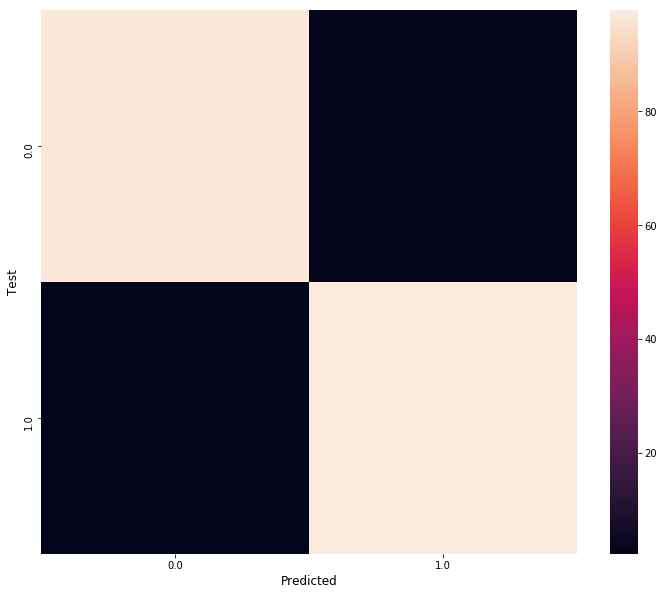

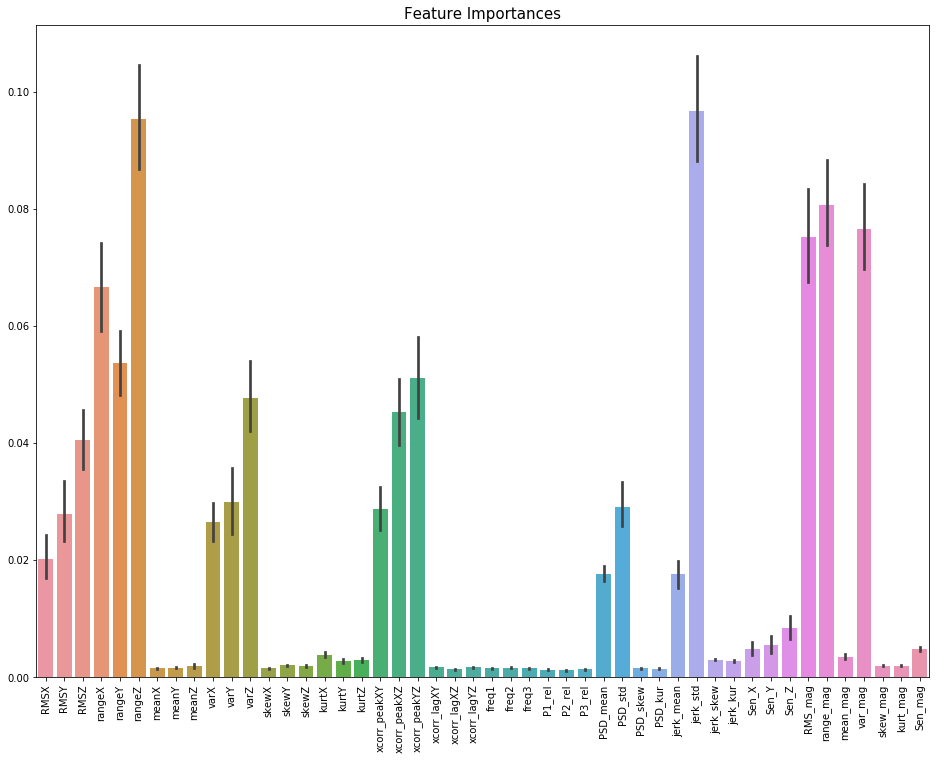

In [56]:
model, FeatImp, TestPred, DataFeatures = DiscernAnomalyModel('Anomaly', 
                                                             ['Stndg', 'Sitng'], 
                                                             [], [])

In [57]:
TestPred

,TestLabs,PredLabs
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,1.0,1.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,1.0


In [45]:
def DiscernAnomalyModel(label_type, tasks, newLab, groups):
    '''label_type: \'TaskAbb\' or \'Tremor\' or \'Bradykinesia\' or \'Dyskinesia\' or \'Overall\' 
    tasks: list of tasks to be considered by the model; pass grouped tasks when modelling scores
    newLab: list of new labels for groups of tasks that should be considered together
    groups: list of lists containing tasks to be grouped together'''
    
    DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'))
    DataFeatures = DataFeatures[DataFeatures.Anomaly == 1]
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
    DataFeatures = DataFeatures[~np.isnan(DataFeatures[label_type].values)]
    if newLab:
        groupDict = {}
        for group, lab in zip(groups, newLab):
            for olab in group:
                groupDict[olab] = lab
    features_list = list(DataFeatures.columns[5:53])
    X = DataFeatures[features_list].values
    if newLab:
        Y = DataFeatures[label_type].apply(lambda x: groupDict[x]).values
    else:
        Y = DataFeatures[label_type].values
    le.fit(Y)
    Y = le.transform(Y)
    CM = np.zeros(shape = (len(set(Y)), len(set(Y))))
    FeatImp = np.zeros(shape = (1, 1))
    j = True
    k = True
    plt.figure(figsize = (12, 10))
    for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]
        TestFeat = X[testInd]
        TestLab = Y[testInd]
        cf.fit(TrainFeat, TrainLab)
        if len(groups) == 2:
            PredLabP = []
            i = True
            treeNum = 0
            trees = []
            AUC = []
            for tree in cf.estimators_:
                treePredLab = tree.predict(TestFeat)
                treeNum += 1
                if i:
                    PredLab = treePredLab
                    ProbLab = PredLab
                    i = False
                else:
                    PredLab = np.vstack([PredLab, treePredLab])
                    ProbLab = np.mean(PredLab, axis = 0)
                try:
                    AUC = AUC + [sklearn.metrics.roc_auc_score(TestLab, ProbLab)]
                    trees = trees + [treeNum]
                except(ValueError):
                    break
            if j:
                ProbLabCV = [list(ProbLab)]
                TestLabCV = [list(TestLab)]
                j = False
            else:
                ProbLabCV = ProbLabCV + [list(ProbLab)]
                TestLabCV = TestLabCV + [list(TestLab)]
            plt.plot(trees, AUC)
            plt.xlabel('Trees', fontsize = 12)
            plt.ylabel('Area Under ROC Curve', fontsize = 12)
            plt.title('Model Iteration Accuracy', fontsize = 15)
            plt.ylim((0, 1))
        if len(FeatImp) > 1:
            FeatImp = np.vstack((FeatImp, cf.feature_importances_))
        else:
            FeatImp = cf.feature_importances_
        PredLab = cf.predict(TestFeat)
        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)
        if k:
            TestLabs = list(TestLab)
            PredLabs = list(PredLab)
            testInds = list(testInd)
            k = False
        else:
            TestLabs = TestLabs + list(TestLab)
            PredLabs = PredLabs + list(PredLab)
            testInds = testInds + list(testInd)
        CM = CM + sklearn.metrics.confusion_matrix(TestLab, PredLab, labels = le.classes_)
    TestPred = pd.DataFrame(index = testInds)
    TestPred['TestLabs'] = TestLabs
    TestPred['PredLabs'] = PredLabs
    for i in range(len(CM)):
        CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100 
    if len(groups) == 2:
        plt.show()
        plt.figure(figsize = (12, 10))
        for PL, TL in zip(ProbLabCV, TestLabCV):
            if len(set(TL)) == 1:
                continue
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(TL, PL)
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate', fontsize = 12)
            plt.ylabel('True Positive Rate', fontsize = 12)
            plt.title('Receiver Operating Characteristic Curve', fontsize = 15)
        plt.show()
    if len(groups) == 2:
        plt.figure(figsize = (6, 5))
    else:
        plt.figure(figsize = (12, 10))
    sns.heatmap(CM, xticklabels = le.classes_, yticklabels = le.classes_)
    plt.xlabel('Predicted', fontsize = 12)
    plt.ylabel('Test', fontsize = 12)
    plt.figure(figsize = (16, 12))
    sns.barplot(data = pd.DataFrame(FeatImp, columns = features_list))
    plt.xticks(rotation = 90)
    plt.title('Feature Importances', fontsize = 15)
    
    return cf, FeatImp, TestPred, DataFeatures

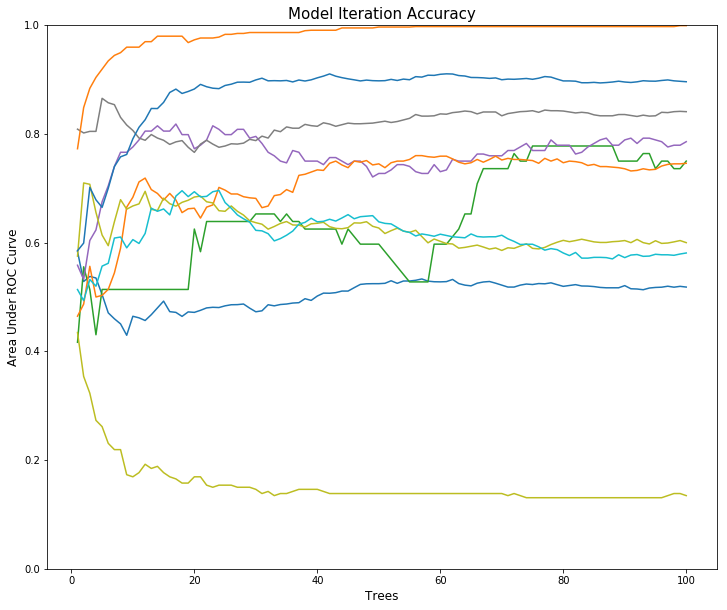

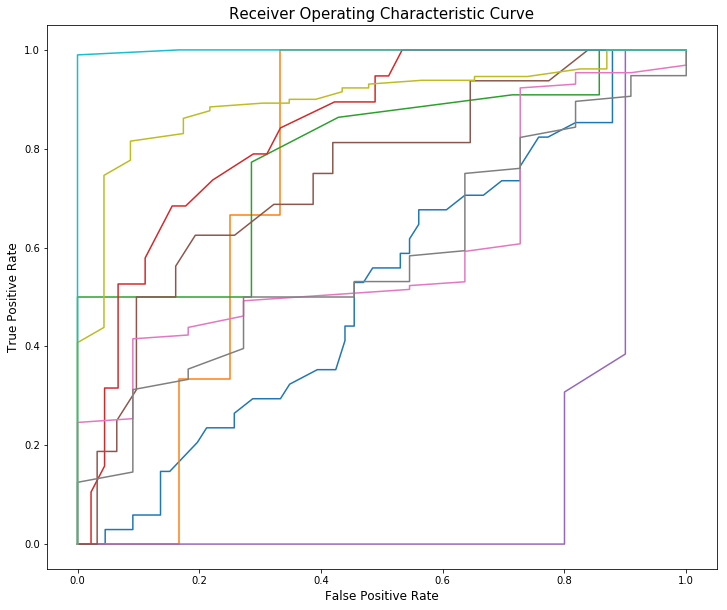

1558
1558


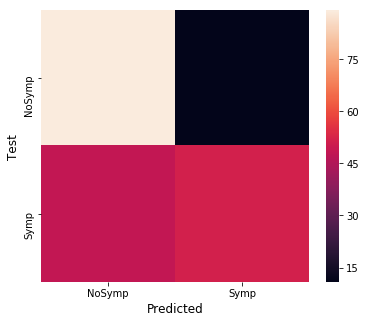

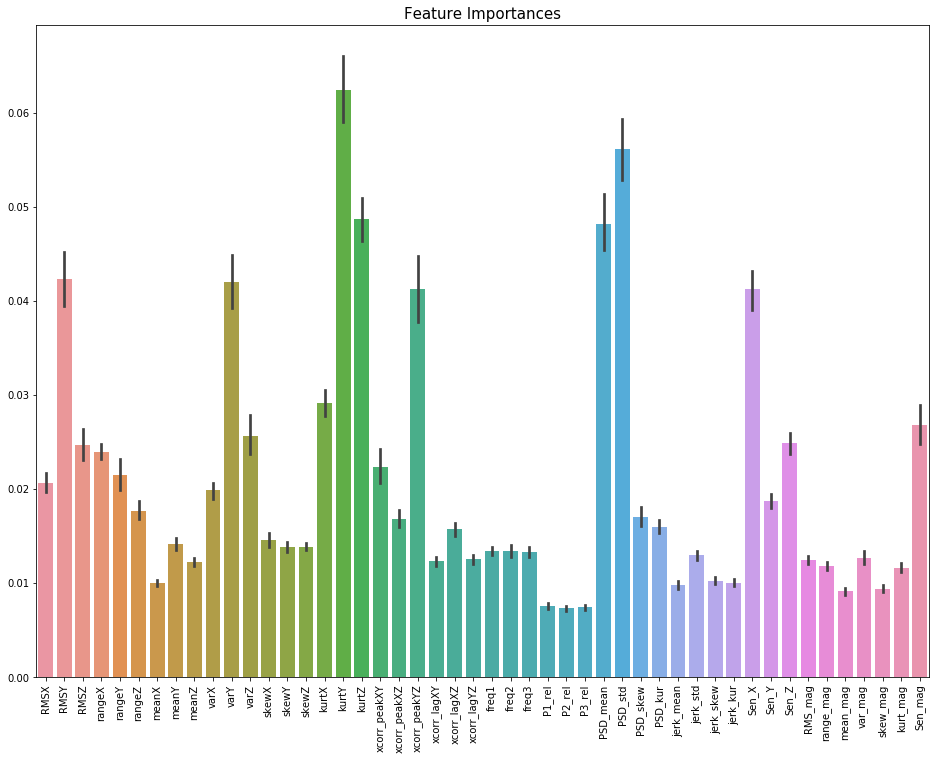

In [49]:
model, FeatImp, TestPred, DataFeatures = DiscernAnomalyModel('Tremor', 
                                                             ['Stndg', 'Sitng'], 
                                                             ['NoSymp', 'Symp'], 
                                                             [[float(0)], [float(1), float(2), float(3), float(4)]])

In [68]:
def DetectDiscernAnomalyModel(label_type, tasks, newLab, groups):
    '''label_type: \'TaskAbb\' or \'Tremor\' or \'Bradykinesia\' or \'Dyskinesia\' or \'Overall\' 
    tasks: list of tasks to be considered by the model; pass grouped tasks when modelling scores
    newLab: list of new labels for groups of tasks that should be considered together
    groups: list of lists containing tasks to be grouped together'''
    
    
    
    
    DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'))
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
    DataFeatures = DataFeatures[~np.isnan(DataFeatures[label_type].values)]
    features_list = list(DataFeatures.columns[5:53])
    X = DataFeatures[features_list].values
    Y = DataFeatures['Anomaly'].values
    le.fit(Y)
    Y = le.transform(Y)
    j = True
    k = True
    for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]
        TestFeat = X[testInd]
        TestLab = Y[testInd]
        cf.fit(TrainFeat, TrainLab)
        PredLab = cf.predict(TestFeat)
        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)
        if k:
            TestLabs = list(TestLab)
            PredLabs = list(PredLab)
            testInds = list(testInd)
            k = False
        else:
            TestLabs = TestLabs + list(TestLab)
            PredLabs = PredLabs + list(PredLab)
            testInds = testInds + list(testInd)
    TestPred = pd.DataFrame(index = testInds)
    TestPred['TestLabs'] = TestLabs
    TestPred['PredLabs'] = PredLabs
    
    
    
    # only look at clips predicted to have an anomaly present
    # find a way to predict anomaly finder first and only train/test on those predicted to have anomaly immediately
    # is this doing the same thing?
    DataFeatures = DataFeatures[TestPred.PredLabs == 1]
    
    if newLab:
        groupDict = {}
        for group, lab in zip(groups, newLab):
            for olab in group:
                groupDict[olab] = lab
    features_list = list(DataFeatures.columns[5:53])
    X = DataFeatures[features_list].values
    if newLab:
        Y = DataFeatures[label_type].apply(lambda x: groupDict[x]).values
    else:
        Y = DataFeatures[label_type].values
    le.fit(Y)
    Y = le.transform(Y)
    CM = np.zeros(shape = (len(set(Y)), len(set(Y))))
    FeatImp = np.zeros(shape = (1, 1))
    j = True
    k = True
    plt.figure(figsize = (12, 10))
    for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]
        TestFeat = X[testInd]
        TestLab = Y[testInd]
        cf.fit(TrainFeat, TrainLab)
        if len(groups) == 2:
            PredLabP = []
            i = True
            treeNum = 0
            trees = []
            AUC = []
            for tree in cf.estimators_:
                treePredLab = tree.predict(TestFeat)
                treeNum += 1
                if i:
                    PredLab = treePredLab
                    ProbLab = PredLab
                    i = False
                else:
                    PredLab = np.vstack([PredLab, treePredLab])
                    ProbLab = np.mean(PredLab, axis = 0)
                try:
                    AUC = AUC + [sklearn.metrics.roc_auc_score(TestLab, ProbLab)]
                    trees = trees + [treeNum]
                except(ValueError):
                    break
            if j:
                ProbLabCV = [list(ProbLab)]
                TestLabCV = [list(TestLab)]
                j = False
            else:
                ProbLabCV = ProbLabCV + [list(ProbLab)]
                TestLabCV = TestLabCV + [list(TestLab)]
            plt.plot(trees, AUC)
            plt.xlabel('Trees', fontsize = 12)
            plt.ylabel('Area Under ROC Curve', fontsize = 12)
            plt.title('Model Iteration Accuracy', fontsize = 15)
            plt.ylim((0, 1))
        if len(FeatImp) > 1:
            FeatImp = np.vstack((FeatImp, cf.feature_importances_))
        else:
            FeatImp = cf.feature_importances_
        PredLab = cf.predict(TestFeat)
        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)
        if k:
            TestLabs = list(TestLab)
            PredLabs = list(PredLab)
            testInds = list(testInd)
            k = False
        else:
            TestLabs = TestLabs + list(TestLab)
            PredLabs = PredLabs + list(PredLab)
            testInds = testInds + list(testInd)
        CM = CM + sklearn.metrics.confusion_matrix(TestLab, PredLab, labels = le.classes_)
    TestPred = pd.DataFrame(index = testInds)
    TestPred['TestLabs'] = TestLabs
    TestPred['PredLabs'] = PredLabs
    for i in range(len(CM)):
        CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100 
    if len(groups) == 2:
        plt.show()
        plt.figure(figsize = (12, 10))
        for PL, TL in zip(ProbLabCV, TestLabCV):
            if len(set(TL)) == 1:
                continue
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(TL, PL)
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate', fontsize = 12)
            plt.ylabel('True Positive Rate', fontsize = 12)
            plt.title('Receiver Operating Characteristic Curve', fontsize = 15)
        plt.show()
    if len(groups) == 2:
        plt.figure(figsize = (6, 5))
    else:
        plt.figure(figsize = (12, 10))
    sns.heatmap(CM, xticklabels = le.classes_, yticklabels = le.classes_)
    plt.xlabel('Predicted', fontsize = 12)
    plt.ylabel('Test', fontsize = 12)
    plt.figure(figsize = (16, 12))
    sns.barplot(data = pd.DataFrame(FeatImp, columns = features_list))
    plt.xticks(rotation = 90)
    plt.title('Feature Importances', fontsize = 15)
    
    return cf, FeatImp, TestPred, DataFeatures

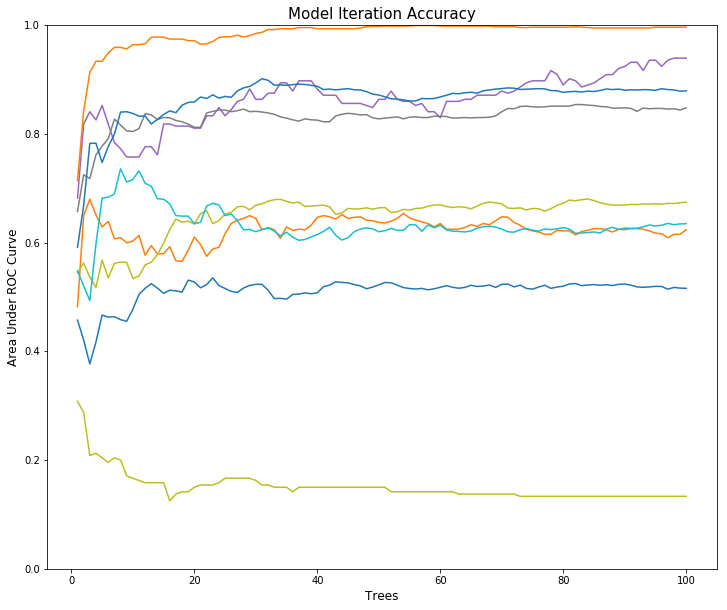

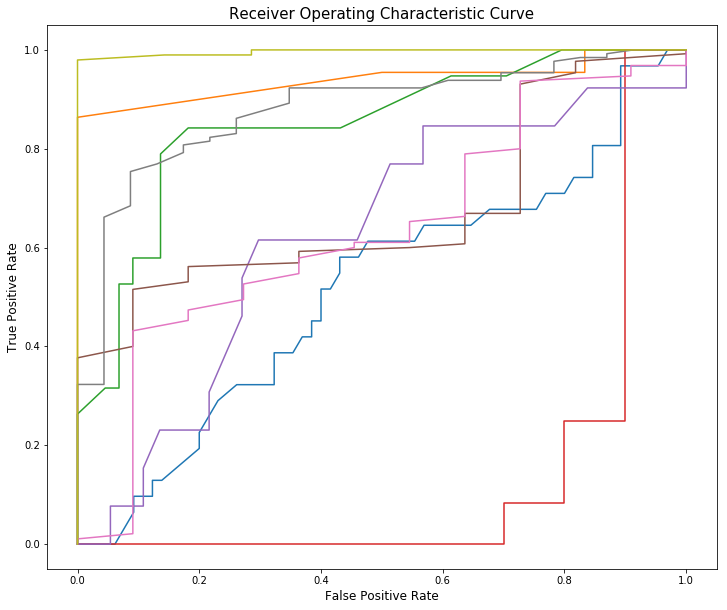

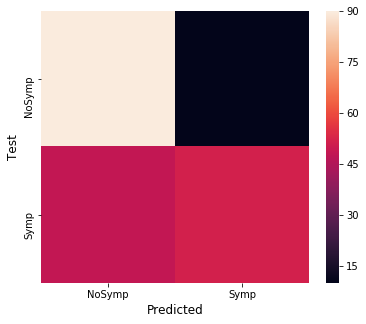

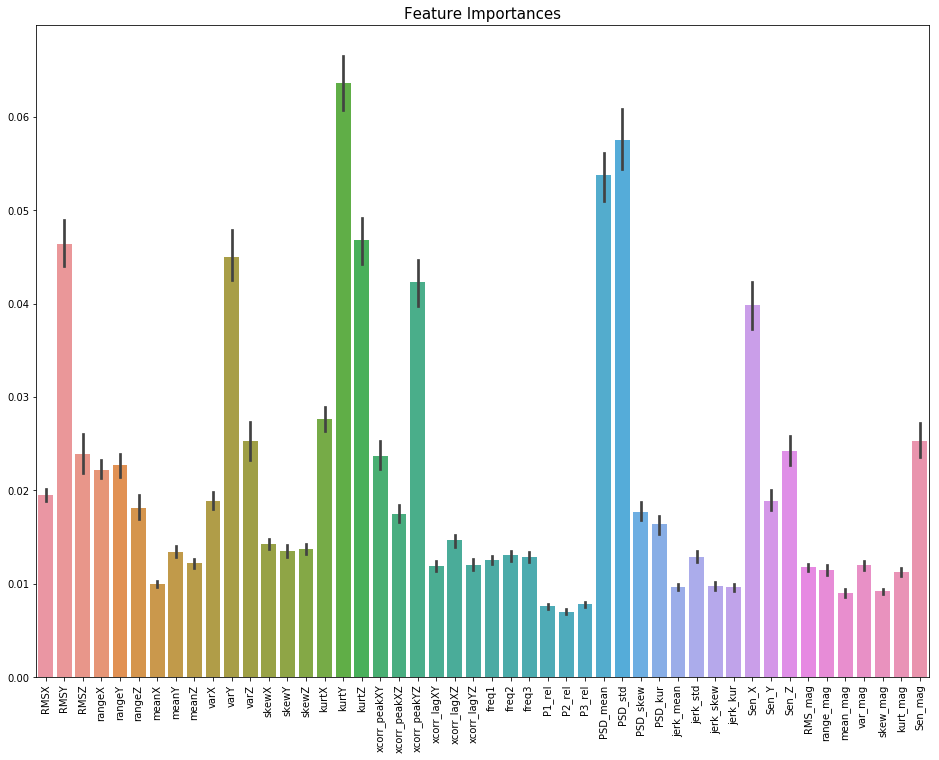

In [69]:
model, FeatImp, TestPred, DataFeatures = DetectDiscernAnomalyModel('Tremor', 
                                                                   ['Stndg', 'Sitng'], 
                                                                   ['NoSymp', 'Symp'], 
                                                                   [[float(0)], [float(1), float(2), float(3), float(4)]])